In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process, fuzz
from tqdm import tqdm
from scipy.stats import skew
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


Load and Understand the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = '/content/drive/My Drive/Project/Update final project/bank_transactions.csv'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1045170 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1045170 non-null  object 
 1   CustomerID               1045170 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1044133 non-null  object 
 4   CustLocation             1045019 non-null  object 
 5   CustAccountBalance       1042802 non-null  float64
 6   TransactionDate          1045170 non-null  object 
 7   TransactionTime          1045170 non-null  int64  
 8   TransactionAmount (INR)  1045170 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 79.7+ MB


In [ ]:
df.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                   0
CustGender                 1037
CustLocation                151
CustAccountBalance         2368
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

Data Preprocessing
- Handle missing values
- Convert categorical data to numerical
- Outlier detection
- Normalize or scale features

In [ ]:
df = df.dropna(subset=['CustomerDOB'])  # Drop rows with missing values

In [ ]:
df['CustGender'] = df['CustGender'].fillna(df['CustGender'].mode()[0])  # Fill missing
df['CustLocation'] = df['CustLocation'].fillna(df['CustLocation'].mode()[0])  # Fill missing
df['CustAccountBalance'] = df['CustAccountBalance'].fillna(df['CustAccountBalance'].median())  # Fill missing

In [ ]:
df.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [ ]:
# Convert DOB to age
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'],errors='coerce')
df['CustomerAge'] = (datetime.now() - df['CustomerDOB']).dt.days // 365

C:\Users\arivu\AppData\Local\Temp\ipykernel_8156\4277697779.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'],errors='coerce')


In [ ]:
today = pd.to_datetime("today")

# Count how many dates are in the future
future_dobs = df[df['CustomerDOB'] > today]
print(f"Future DOBs count: {len(future_dobs)}")
print(future_dobs[['CustomerID', 'CustomerDOB']].head())

Future DOBs count: 105201
   CustomerID CustomerDOB
1    C2142763  2057-04-04
3    C5342380  2073-09-14
5    C1536588  2072-08-10
15   C8334633  2068-10-07
30   C7648712  2067-01-21


In [ ]:
# customerAge count less then 18
underage_customers = df[df['CustomerAge'] < 18]
print(f"Underage customers count: {len(underage_customers)}")
print(underage_customers[['CustomerID', 'CustomerAge']].head())

Underage customers count: 105395
   CustomerID  CustomerAge
1    C2142763          -32
3    C5342380          -49
5    C1536588          -48
15   C8334633          -44
30   C7648712          -42


In [ ]:
df = df[(df['CustomerDOB'] <= today) & (df['CustomerAge'] >= 18)]
df['CustomerAge'] = df['CustomerAge'].astype(int)  # Ensure age is an integer

In [ ]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,30
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2/8/16,142712,459.0,28
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,37
6,T7,C7126560,1992-01-26,F,MUMBAI,973.46,2/8/16,173806,566.0,33
7,T8,C1220223,1982-01-27,M,MUMBAI,95075.54,2/8/16,170537,148.0,43


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 939775 entries, 0 to 1048566
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            939775 non-null  object        
 1   CustomerID               939775 non-null  object        
 2   CustomerDOB              939775 non-null  datetime64[ns]
 3   CustGender               939775 non-null  object        
 4   CustLocation             939775 non-null  object        
 5   CustAccountBalance       939775 non-null  float64       
 6   TransactionDate          939775 non-null  object        
 7   TransactionTime          939775 non-null  int64         
 8   TransactionAmount (INR)  939775 non-null  float64       
 9   CustomerAge              939775 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 78.9+ MB


In [ ]:
df['CustLocation'].value_counts()  # Display top 10 locations after mapping

CustLocation
MUMBAI                                 107891
BANGALORE                               83314
NEW DELHI                               75503
GURGAON                                 66799
DELHI                                   65026
NOIDA                                   29879
PUNE                                    27282
CHENNAI                                 26791
THANE                                   24250
HYDERABAD                               22896
KOLKATA                                 16719
GHAZIABAD                               14071
NAVI MUMBAI                             11981
AHMEDABAD                               11528
FARIDABAD                               10364
JAIPUR                                   9640
CHANDIGARH                               8696
LUCKNOW                                  7100
MOHALI                                   6344
SURAT                                    5585
NASHIK                                   5119
LUDHIANA             

In [ ]:
city_state_map = pd.read_csv("city name.csv")
city_state_map.head()

,circlename,regionname,divisionname,officename,pincode,officetype,delivery,district,statename,latitude,longitude
0,Andhra Pradesh Circle,Vijayawada Region,Tenali Division,Vallabharaopalem B.O,522124,BO,Delivery,GUNTUR,ANDHRA PRADESH,NaN,NaN
1,Andhra Pradesh Circle,Vijayawada Region,Tenali Division,Vupparapalem B.O,522124,BO,Delivery,GUNTUR,ANDHRA PRADESH,NaN,NaN
2,Andhra Pradesh Circle,Vijayawada Region,Tenali Division,Murukondapadu B.O,522317,BO,Delivery,Bapatla,ANDHRA PRADESH,NaN,NaN
3,Andhra Pradesh Circle,Vijayawada Region,Tenali Division,Pedagadelavarru B.O,522318,BO,Delivery,Bapatla,ANDHRA PRADESH,NaN,NaN
4,Andhra Pradesh Circle,Vijayawada Region,Tenali Division,Alapadu B.O,522312,BO,Delivery,Bapatla,ANDHRA PRADESH,NaN,NaN


In [ ]:
city_state_dict = dict(zip(city_state_map['officename'].str.upper(), city_state_map['statename']))

In [ ]:
# Step 1: Extract unique customer locations
unique_cities = df['CustLocation'].dropna().str.upper().unique()

# Step 2: Match only unique values
city_match_dict = {}

print("Matching unique cities...")
for city in tqdm(unique_cities):
    match, score, _ = process.extractOne(city, city_state_dict.keys(), scorer=fuzz.WRatio)
    if score >= 90:
        city_match_dict[city] = match
    else:
        city_match_dict[city] = None

# Step 3: Map back to full DataFrame
df['Matched_City'] = df['CustLocation'].str.upper().map(city_match_dict)
df['State'] = df['Matched_City'].map(city_state_dict)

Matching unique cities...


100%|██████████| 8642/8642 [34:47<00:00,  4.14it/s]


In [ ]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),CustomerAge,Matched_City,State
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,30,JAMSHEDPUR HO,JHARKHAND
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2/8/16,142712,459.0,28,MANDVI S.O (MUMBAI),MAHARASHTRA
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,37,None,NaN
6,T7,C7126560,1992-01-26,F,MUMBAI,973.46,2/8/16,173806,566.0,33,MANDVI S.O (MUMBAI),MAHARASHTRA
7,T8,C1220223,1982-01-27,M,MUMBAI,95075.54,2/8/16,170537,148.0,43,MANDVI S.O (MUMBAI),MAHARASHTRA


In [ ]:
df = df.drop(columns=['Matched_City','TransactionID','TransactionDate','CustomerDOB','CustLocation','TransactionTime','CustomerID'],errors='ignore')  # Drop unnecessary columns

In [ ]:
df['State'] = df['State'].fillna(method='ffill')  # Fill missing states with 'Unknown'

C:\Users\arivu\AppData\Local\Temp\ipykernel_8156\2721408156.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['State'] = df['State'].fillna(method='ffill')  # Fill missing states with 'Unknown'


In [ ]:
# Create mapping dictionary: State → Zone
state_to_zone = {
    # North Zone
    'PUNJAB': 'North', 'HARYANA': 'North', 'DELHI': 'North',
    'HIMACHAL PRADESH': 'North', 'UTTARAKHAND': 'North',
    'JAMMU AND KASHMIR': 'North', 'CHANDIGARH': 'North',

    # South Zone
    'TAMIL NADU': 'South', 'KARNATAKA': 'South', 'KERALA': 'South',
    'ANDHRA PRADESH': 'South', 'TELANGANA': 'South',
    'PUDUCHERRY': 'South', 'LAKSHADWEEP': 'South',

    # East Zone
    'WEST BENGAL': 'East', 'ODISHA': 'East', 'BIHAR': 'East',
    'JHARKHAND': 'East',

    # West Zone
    'RAJASTHAN': 'West', 'GUJARAT': 'West', 'MAHARASHTRA': 'West',
    'GOA': 'West', 'THE DADRA AND NAGAR HAVELI AND DAMAN AND DIU': 'West',

    # Central Zone
    'UTTAR PRADESH': 'Central', 'MADHYA PRADESH': 'Central',
    'CHHATTISGARH': 'Central',

    # North-East Zone
    'ASSAM': 'North-East', 'ARUNACHAL PRADESH': 'North-East',
    'NAGALAND': 'North-East', 'MEGHALAYA': 'North-East',
    'MANIPUR': 'North-East', 'MIZORAM': 'North-East',
    'TRIPURA': 'North-East', 'SIKKIM': 'North-East',

    # Islands
    'ANDAMAN AND NICOBAR ISLANDS': 'Islands'
}

# Apply mapping to create a new 'Zone' column
df['Zone'] = df['State'].map(state_to_zone)


In [ ]:
df = df.drop(columns=['State'])

In [ ]:
#df.to_csv('bank_transactions_cleaned.csv', index=False)  # Save cleaned data

In [ ]:
df1 = pd.read_csv('bank_transactions_cleaned.csv')
df1.head()

,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Zone
0,F,17819.05,25.0,30,East
1,F,17874.44,459.0,28,West
2,F,6714.43,1762.5,37,West
3,F,973.46,566.0,33,West
4,M,95075.54,148.0,43,West


- Convert Categorical data to Numerical
    - Label Encoding
    - One-hot Encoding

In [ ]:
df1['Zone'].value_counts()

Zone
Central       321780
West          223069
North         155660
South         127800
East           82279
North-East     29134
Islands           53
Name: count, dtype: int64

In [ ]:
le = LabelEncoder()
df1['CustGender'] = le.fit_transform(df1['CustGender'])

In [ ]:
df1 = pd.get_dummies(df1, columns=['Zone'], drop_first=True).astype(int)  # One-hot encoding for 'Zone'
df1.head()

,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Zone_East,Zone_Islands,Zone_North,Zone_North-East,Zone_South,Zone_West
0,0,17819,25,30,1,0,0,0,0,0
1,0,17874,459,28,0,0,0,0,0,1
2,0,6714,1762,37,0,0,0,0,0,1
3,0,973,566,33,0,0,0,0,0,1
4,1,95075,148,43,0,0,0,0,0,1


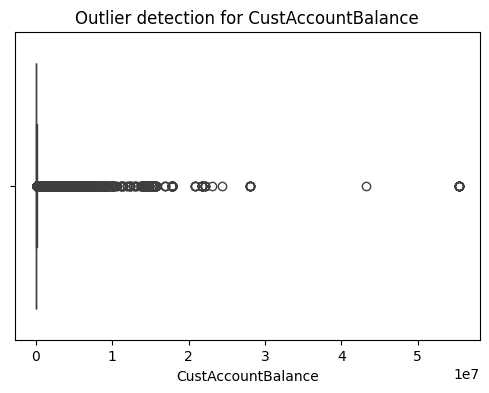

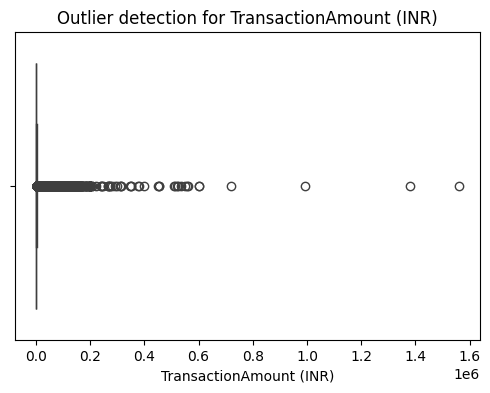

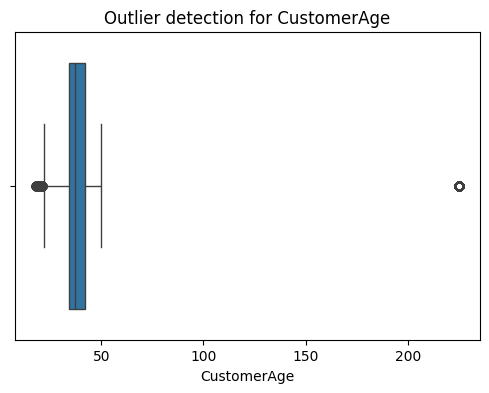

In [ ]:
for col in ['CustAccountBalance', 'TransactionAmount (INR)', 'CustomerAge']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df1[col])
    plt.title(f"Outlier detection for {col}")
    plt.show()

In [ ]:
outlier_cols = ['CustAccountBalance', 'TransactionAmount (INR)', 'CustomerAge']

def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # Print how many outliers found
        print(f"{col}: Outliers before = {df[(df[col] < lower_limit) | (df[col] > upper_limit)].shape[0]}")

        # Remove outliers
        df = df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]

        # Print after removing
        print(f"{col}: Remaining rows = {df.shape[0]}")
        print("-"*50)
    return df

# Apply
df_cleaned = remove_outliers_iqr(df1, outlier_cols)

CustAccountBalance: Outliers before = 122421
CustAccountBalance: Remaining rows = 817354
--------------------------------------------------
TransactionAmount (INR): Outliers before = 81449
TransactionAmount (INR): Remaining rows = 735905
--------------------------------------------------
CustomerAge: Outliers before = 31322
CustomerAge: Remaining rows = 704583
--------------------------------------------------


In [ ]:
df_cleaned.shape

(704583, 10)

 Normalization and Scaling (Standardization)
 - Min-Max Scaling
 - StandardScaler

In [ ]:
scaler = StandardScaler()
# Scale the numerical features
numerical_cols = ['CustAccountBalance', 'TransactionAmount (INR)', 'CustomerAge']
df_cleaned[numerical_cols] = scaler.fit_transform(df_cleaned[numerical_cols])


In [ ]:
df_cleaned.head()

,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Zone_East,Zone_Islands,Zone_North,Zone_North-East,Zone_South,Zone_West
0,0,-0.107136,-0.905108,-1.367967,1,0,0,0,0,0
1,0,-0.104935,-0.067615,-1.764932,0,0,0,0,0,1
2,0,-0.551691,2.446793,0.021412,0,0,0,0,0,1
3,0,-0.781514,0.138863,-0.772519,0,0,0,0,0,1
4,1,2.985569,-0.667754,1.212307,0,0,0,0,0,1


EDA (Exploratory Data Analysis).
- Check Skewness (Distribution Shape)
- Correlation Analysis
- Detect Anomalies (Boxplots)

Skewness of CustAccountBalance: 1.785900918431945


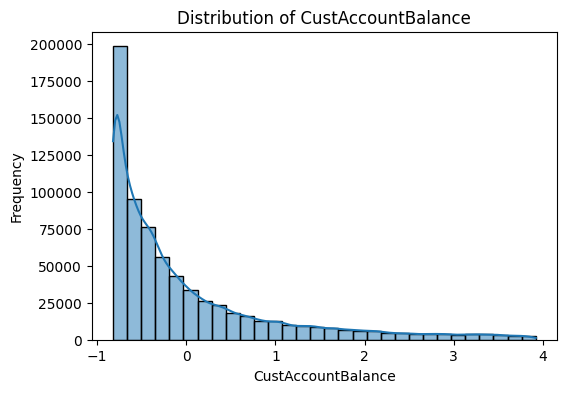

Skewness of TransactionAmount (INR): 1.4870594109754356


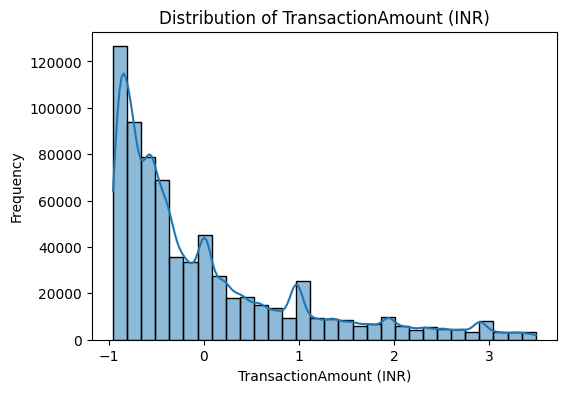

Skewness of CustomerAge: 0.5364051261380882


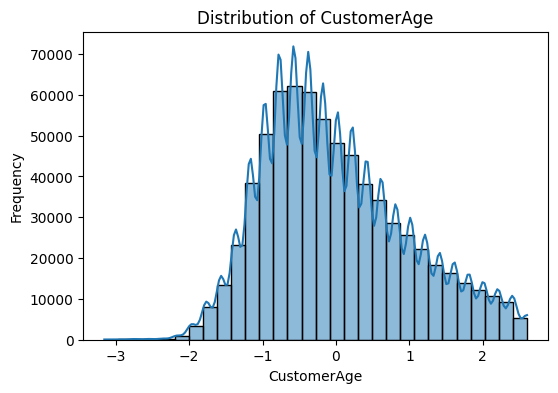

In [ ]:
num_cols = ['CustAccountBalance','TransactionAmount (INR)','CustomerAge']

for col in num_cols:
    print(f"Skewness of {col}: {skew(df_cleaned[col])}")
    plt.figure(figsize=(6,4))
    sns.histplot(df_cleaned[col], kde=True,bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

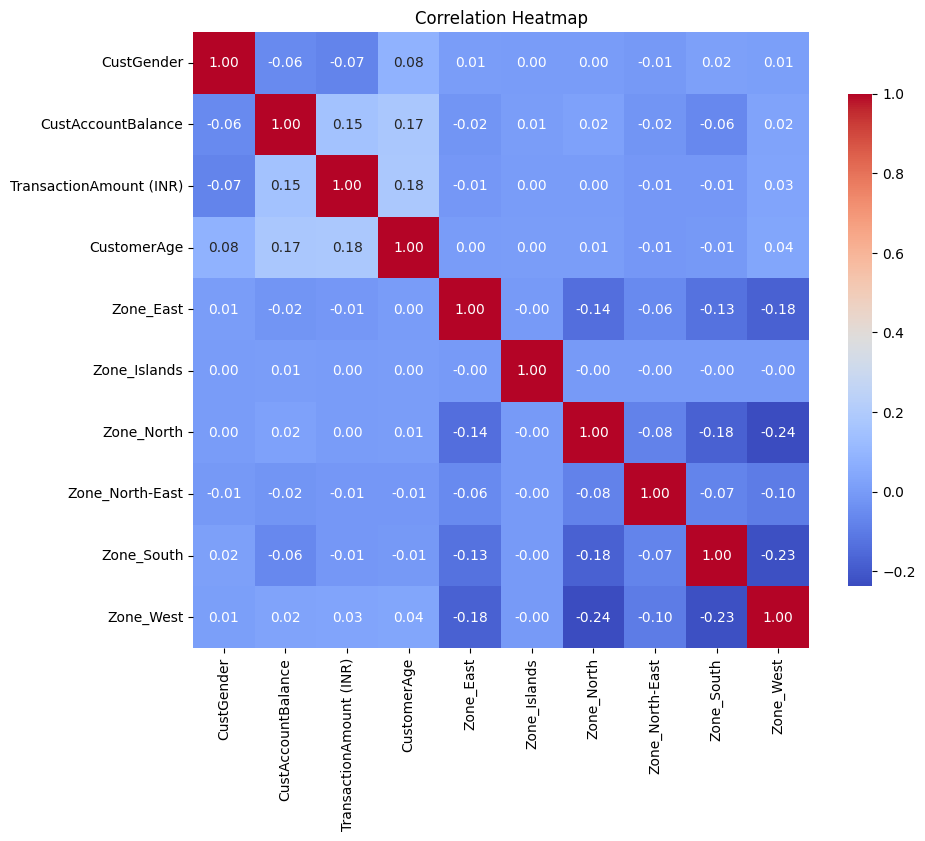

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap")
plt.show()

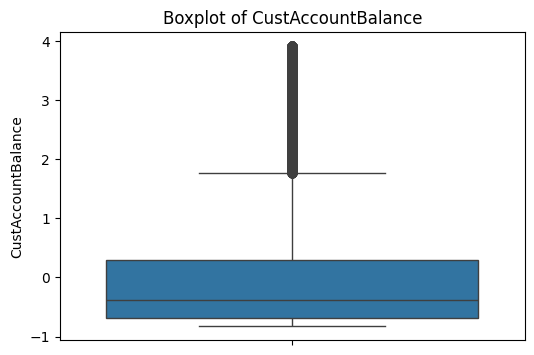

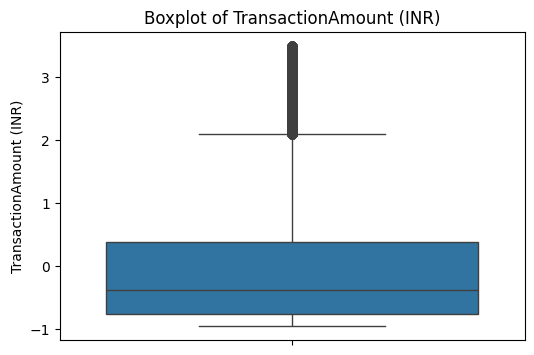

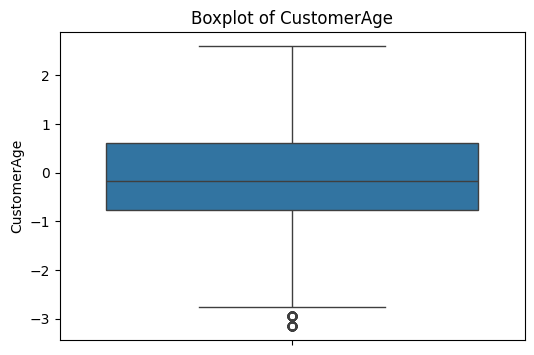

In [ ]:
#Detect Anomalies (Boxplots)
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(df_cleaned[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

Feature Selection
- PCA
- t-SNE

In [ ]:
# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_cleaned)

print(F"Original shape: {df_cleaned.shape}, PCA reduced shape: {X_pca.shape}")

Original shape: (704583, 10), PCA reduced shape: (704583, 2)


C:\Users\arivu\AppData\Local\Temp\ipykernel_13372\1782685999.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


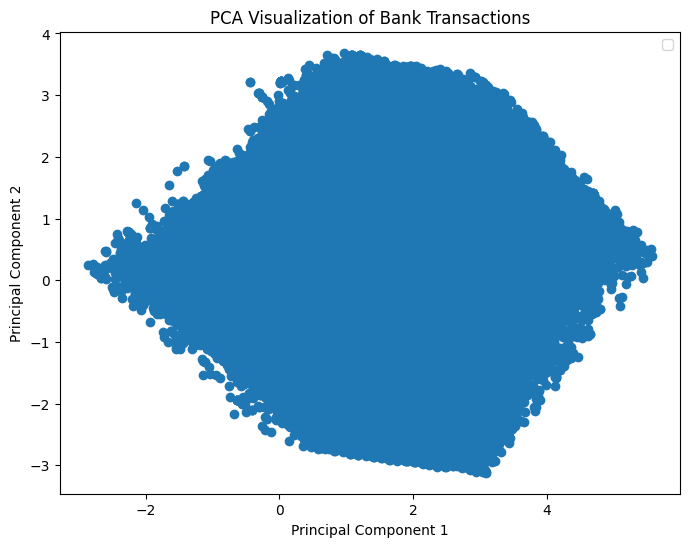

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1],)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Bank Transactions')
plt.legend()
plt.show()

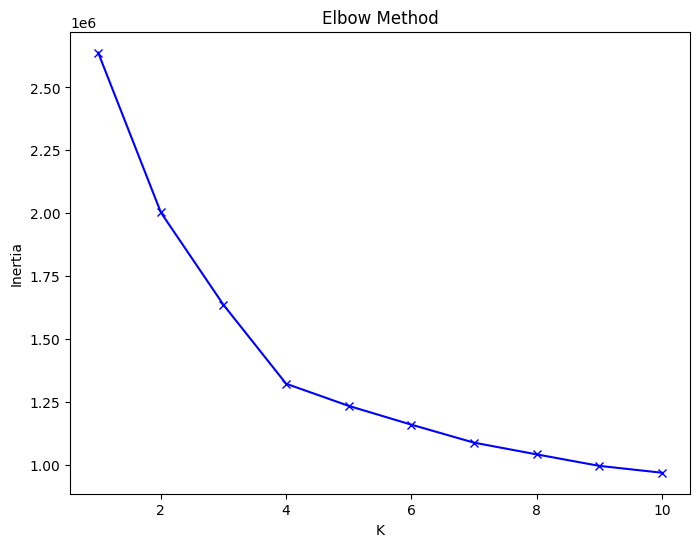

In [ ]:
# Elbow Method to find optimal K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cleaned)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

K=2, Silhouette Score=0.2904
K=3, Silhouette Score=0.2617
K=4, Silhouette Score=0.2276
K=5, Silhouette Score=0.2263
K=6, Silhouette Score=0.1521
K=7, Silhouette Score=0.1307
K=8, Silhouette Score=0.1704
K=9, Silhouette Score=0.1606
K=10, Silhouette Score=0.1614


C:\Users\arivu\AppData\Local\Temp\ipykernel_13372\1228659312.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bx-" (-> marker='x'). The keyword argument will take precedence.
  plt.plot(K_range, silhouette_scores, 'bx-',marker='o',markersize=8)


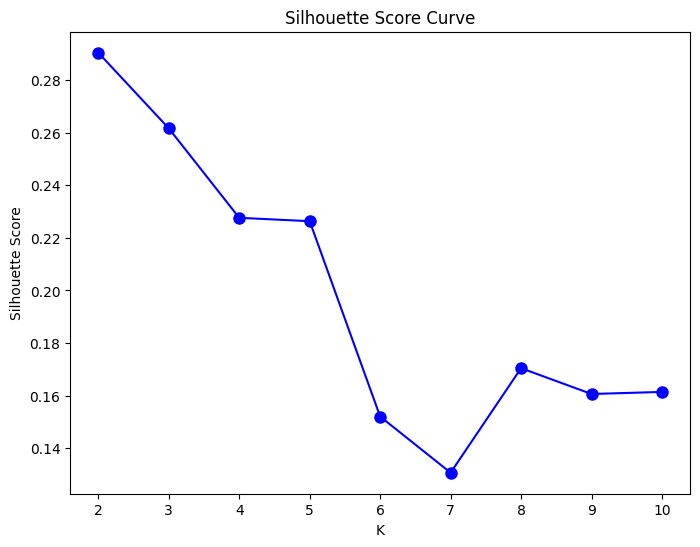

In [ ]:
# Silhouette Score curve
silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
    labels = mbk.fit_predict(df_cleaned)
    score = silhouette_score(df_cleaned, labels, sample_size=100000)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(K_range, silhouette_scores, 'bx-',marker='o',markersize=8)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Curve')
plt.show()

In [ ]:
print(f"Optimal K based on Silhouette Score: {K_range[np.argmax(silhouette_scores)]}")

Optimal K based on Silhouette Score: 2


In [ ]:
print("Calinski-Harabasz:", calinski_harabasz_score(df_cleaned, labels))


Calinski-Harabasz: 134018.7675917664


In [ ]:
print("Davies-Bouldin:", davies_bouldin_score(df_cleaned, labels))

Davies-Bouldin: 1.6071074799002911


Apply Algorithm
- K-Means Clustering
- Hierarchical Clustering (Agglomerative)
- DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
- Gaussian Mixture Models (GMM)

C:\Users\arivu\AppData\Local\Temp\ipykernel_13372\3432465424.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


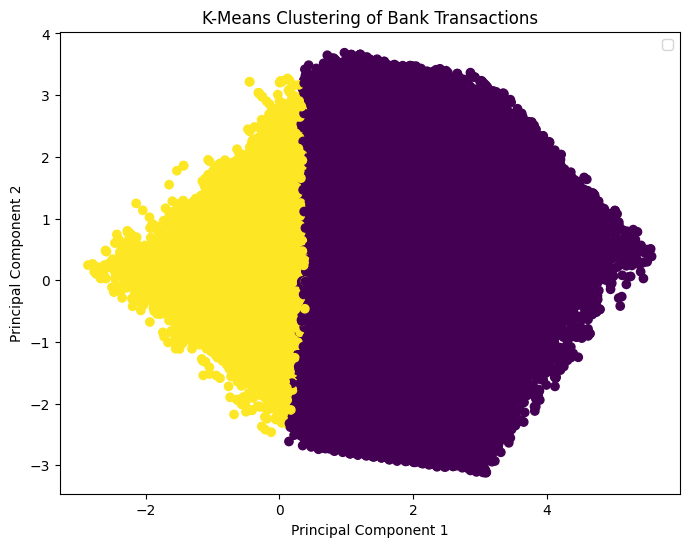

In [ ]:
# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_cleaned)

# Visualize K-Means Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Bank Transactions')
plt.legend()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The project aimed to analyze bank transaction data to understand customer behavior and identify potential segments through clustering.
*   The dataset `bank_transactions.csv` was loaded, and initial exploration revealed missing values in `CustGender`, `CustLocation`, and `CustAccountBalance`.
*   Data preprocessing involved dropping rows with missing `CustomerDOB`, filling missing `CustGender` and `CustLocation` with the mode, and filling missing `CustAccountBalance` with the median.
*   The `CustomerDOB` was converted to datetime to calculate `CustomerAge`, and invalid/underage entries were removed.
*   Outliers in `CustAccountBalance`, `TransactionAmount (INR)`, and `CustomerAge` were detected and removed using the IQR method.
*   New features `CustomerAge` and `Zone` (mapped from `CustLocation`) were engineered.
*   Categorical features were encoded: `CustGender` using `LabelEncoder` and `Zone` using one-hot encoding (`pd.get_dummies`) with `drop_first=True`.
*   EDA showed that `CustAccountBalance` and `TransactionAmount (INR)` had significant positive skew, `CustomerAge` had moderate positive skew, and there were no strong linear correlations between features. Boxplots showed remaining potential outliers post-removal.
*   PCA was used to reduce dimensionality to 2 components for visualization; the resulting scatter plot showed data points spread without immediately distinct clusters.
*   K-Means and MiniBatchKMeans clustering were explored, and the optimal number of clusters (K=2) was indicated by the Silhouette Score.
*   K-Means clustering with K=2 was performed and visualized on the 2D PCA projection, showing somewhat intermingled clusters in the 2D space.

### Insights or Next Steps

*   The analysis successfully segmented bank customers into 2 clusters based on their transaction behavior and demographic features, although the clusters were not clearly separated in the 2D PCA visualization.
*   Further steps should include exploring other clustering algorithms, refining the definition and characteristics of the identified clusters, and applying these segments for targeted business strategies like marketing and risk assessment.
